In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%store -r model_df

# pd.set_option('display.width', 200)  # Set a large width
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

with open("model_df.pkl", "rb") as f:
    model_df = pickle.load(f)

print(model_df.head())  # Verify the DataFrame is loaded



   price  price_log  carat  carat_color_interaction  carat_clarity_interaction  quality_composite      volume
0    337   5.823046   0.22                     0.22                       0.88                2.8   36.425214
1   2757   7.922261   0.86                     0.86                       5.16                3.6  143.716320
2   2759   7.922986   0.96                     1.92                       5.76                4.0  151.837455
3   2762   7.924072   0.70                     1.40                       2.80                3.2  110.271518
4   2762   7.924072   0.70                     1.40                       2.80                3.2  114.980364


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/IPython/extensions/storemagic.py:148: UserWarning: This is now an optional IPython functionality, using autorestore/model_df requires you to install the `pickleshare` library.
  obj = db["autorestore/" + arg]


In [443]:

target = ['price_log']
features = ['carat', 'carat_color_interaction', 'carat_clarity_interaction',
       'quality_composite', 'volume']


X = model_df[features]
y = model_df[target]


In [444]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Random Forest

In [445]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Gradient Boosting

In [446]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


### XGBoost

In [447]:
import xgboost as xgb


xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.1,
                              max_depth=5,
                             random_state=42)

# xgb_model = xgb.XGBRegressor(n_estimators=500,
#                              learning_rate=0.01,
#                               max_depth=7,
#                               colsample_bytree = 0.8,
#                              random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


### Evaluate Models

In [448]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"🔹 {model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    print("-" * 40)

# Evaluate all models
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, gb_preds, "Gradient Boosting")
evaluate_model(y_test, xgb_preds, "XGBoost")


🔹 Random Forest Performance:
RMSE: 0.34
MAE: 0.09
R²: 0.99
----------------------------------------
🔹 Gradient Boosting Performance:
RMSE: 0.34
MAE: 0.09
R²: 0.99
----------------------------------------
🔹 XGBoost Performance:
RMSE: 0.33
MAE: 0.08
R²: 0.99
----------------------------------------


### Ensemble Approach (Combine Random Forest & XGBoost)

This blend the prediction of Random Forest and XGBoost

In [449]:
ensemble_pred = (rf_preds + xgb_preds) / 2
rmse_ensemble = np.sqrt(root_mean_squared_error(y_test, ensemble_pred))
mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
r2_ensemble = r2_score(y_test, ensemble_pred)

print(f"🔹 Ensemble Model Performance:")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"MAE: {mae_ensemble:.2f}")
print(f"R²: {r2_ensemble:.2f}")


🔹 Ensemble Model Performance:
RMSE: 0.33
MAE: 0.08
R²: 0.99


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # Metrics on log scale
# rmse_log = np.sqrt(mean_squared_error(y_test, ensemble_pred))
# mae_log = mean_absolute_error(y_test, ensemble_pred)
# r2_log = r2_score(y_test, ensemble_pred)

# print("🔹 Ensemble Model Performance (Log Scale):")
# print(f"RMSE: {rmse_log:.2f}")
# print(f"MAE: {mae_log:.2f}")
# print(f"R²: {r2_log:.2f}")

# # Inverse transform to original scale
# y_test_original = np.expm1(y_test)
# ensemble_pred_original = np.expm1(ensemble_pred)

# # Metrics on original scale
# rmse_original = np.sqrt(mean_squared_error(y_test_original, ensemble_pred_original))
# mae_original = mean_absolute_error(y_test_original, ensemble_pred_original)
# r2_original = r2_score(y_test_original, ensemble_pred_original)

# print("\n🔹 Ensemble Model Performance (Original Scale):")
# print(f"RMSE: {rmse_original:.2f}")
# print(f"MAE: {mae_original:.2f}")
# print(f"R²: {r2_original:.2f}")

🔹 Ensemble Model Performance (Log Scale):
RMSE: 0.11
MAE: 0.08
R²: 0.99

🔹 Ensemble Model Performance (Original Scale):
RMSE: 457.64
MAE: 253.32
R²: 0.98


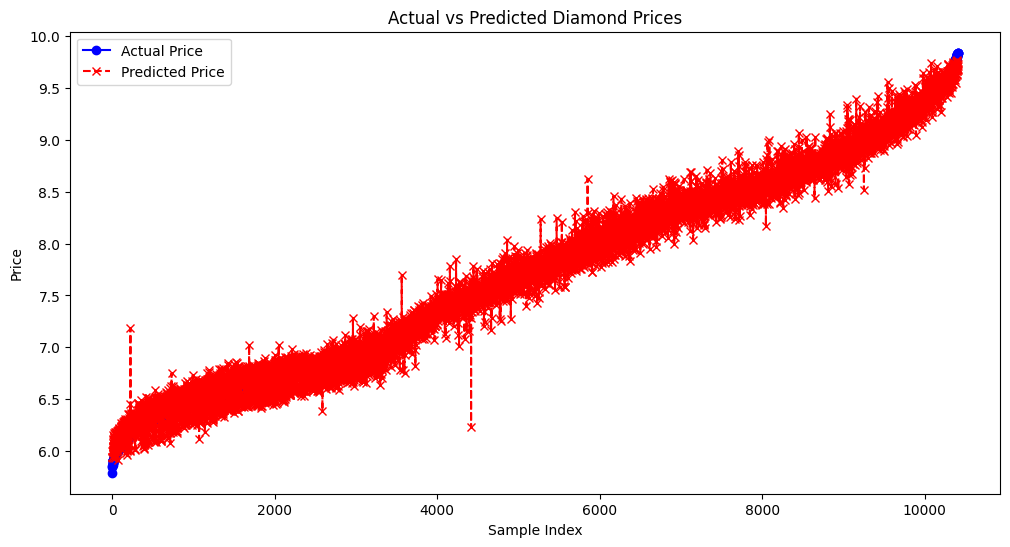

In [451]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure predictions and labels are 1D
ensemble_pred = ensemble_pred.reshape(-1)
y_test_values = y_test.values.reshape(-1)

# Sort values for smooth visualization
sorted_idx = np.argsort(y_test_values)

plt.figure(figsize=(12, 6))
plt.plot(y_test_values[sorted_idx], label="Actual Price", linestyle="-", marker="o", color="blue")
plt.plot(ensemble_pred[sorted_idx], label="Predicted Price", linestyle="--", marker="x", color="red")

plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Diamond Prices")
plt.legend()
plt.show()


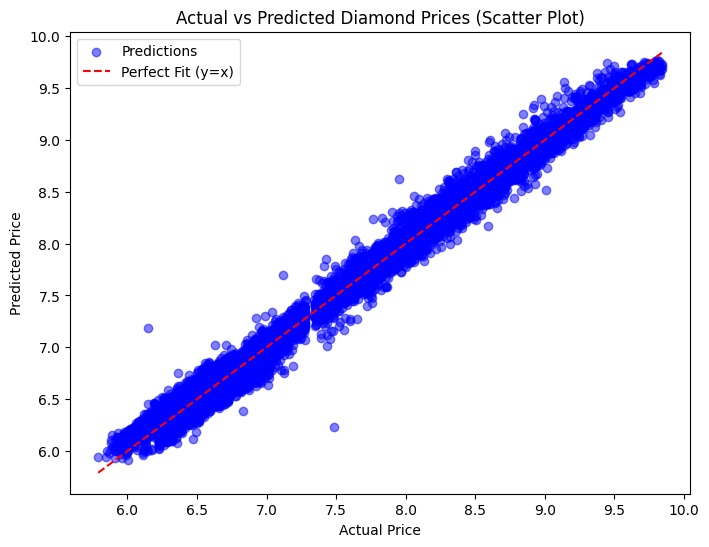

In [452]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_values, ensemble_pred, alpha=0.5, color="blue", label="Predictions")

# Plot a perfect prediction reference line (y = x)
plt.plot([min(y_test_values), max(y_test_values)], [min(y_test_values), max(y_test_values)], 
         linestyle="--", color="red", label="Perfect Fit (y=x)")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Diamond Prices (Scatter Plot)")
plt.legend()
plt.show()


In [453]:
ensemble_pred = np.exp((rf_preds + xgb_preds) / 2)  # Convert back to original scale
y_test_original = np.exp(y_test)  # Ensure y_test is also back to original scale
rmse_ensemble = np.sqrt(root_mean_squared_error(y_test_original, ensemble_pred))
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)
r2_ensemble = r2_score(y_test_original, ensemble_pred)

print(f"🔹 Ensemble Model Performance (Original Scale):")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"MAE: {mae_ensemble:.2f}")
print(f"R²: {r2_ensemble:.2f}")


🔹 Ensemble Model Performance (Original Scale):
RMSE: 21.39
MAE: 253.32
R²: 0.98


In [454]:
import numpy as np

# Check the range of log-scale values
print("y_test (price_log) - Min:", y_test.min(), "Max:", y_test.max())
print("ensemble_pred (price_log) - Min:", ensemble_pred.min(), "Max:", ensemble_pred.max())

# Check for infinite or NaN values
print("y_test contains inf:", np.any(np.isinf(y_test)))
print("y_test contains NaN:", np.any(np.isnan(y_test)))
print("ensemble_pred contains inf:", np.any(np.isinf(ensemble_pred)))
print("ensemble_pred contains NaN:", np.any(np.isnan(ensemble_pred)))

y_test (price_log) - Min: price_log    5.78996
dtype: float64 Max: price_log    9.841825
dtype: float64
ensemble_pred (price_log) - Min: 370.7944843259363 Max: 17484.68599376089
y_test contains inf: False
y_test contains NaN: False
ensemble_pred contains inf: False
ensemble_pred contains NaN: False


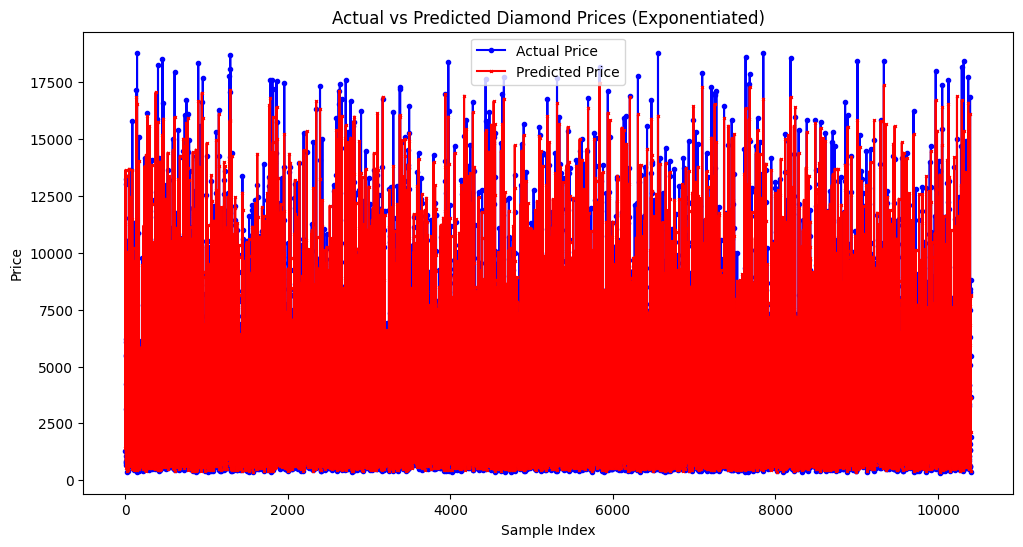

In [455]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_original)), y_test_original, 'bo-', markersize=3, label="Actual Price")
plt.plot(range(len(ensemble_pred)), ensemble_pred, 'rx-', markersize=2, label="Predicted Price")

plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Diamond Prices (Exponentiated)")
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(range(len(y_test_original)), y_test_original, 'bo-', markersize=3, alpha=0.6, label="Actual Price")
# plt.plot(range(len(ensemble_pred)), ensemble_pred, 'rx-', markersize=2, alpha=0.3, label="Predicted Price")

# plt.xlabel("Sample Index")
# plt.ylabel("Price")
# plt.title("Actual vs Predicted Diamond Prices (Exponentiated)")
# plt.legend()
# plt.show()



# Hyperparameters Tuning

In [456]:
#XGBoost

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
best_xgb = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
